In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv('data/prediction.csv')
data['error'] = abs(data['actual_production_values'] - data['predicted_production_values'])

mae = mean_absolute_error(data['actual_production_values'], data['predicted_production_values'])
rmse = np.sqrt(mean_squared_error(data['actual_production_values'], data['predicted_production_values']))

plt.figure(figsize=(10, 6))
plt.hist(data['error'], bins=10, color='lightblue', edgecolor='black')
plt.title('Error Distribution (Actual vs Predicted)')
plt.xlabel('Error (Absolute Difference)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

KeyError: 'predicted_production_values'

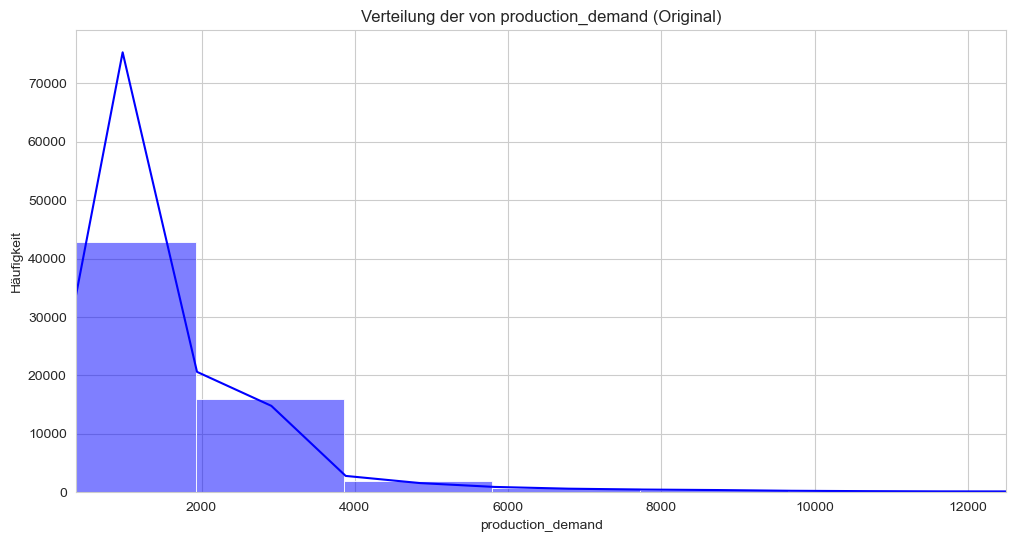

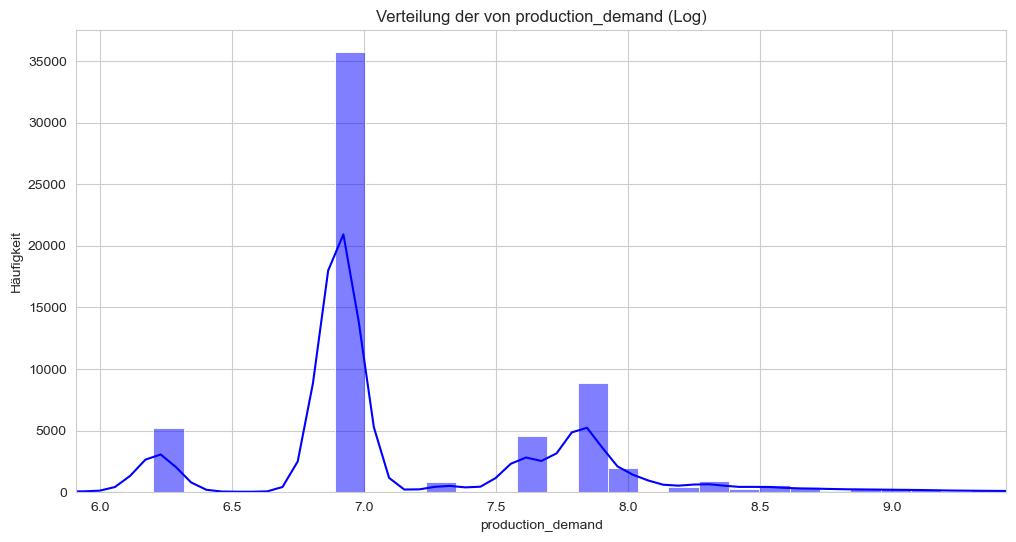

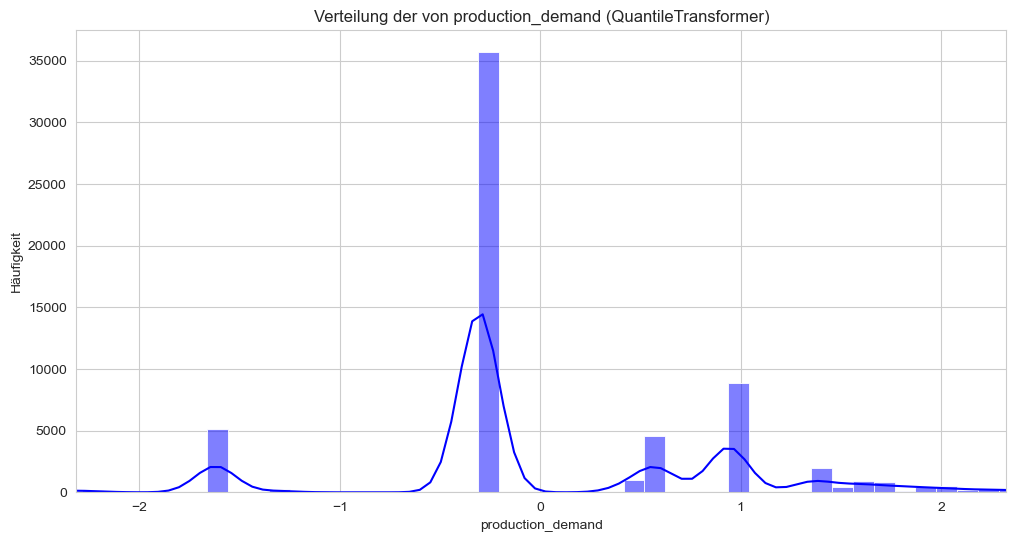

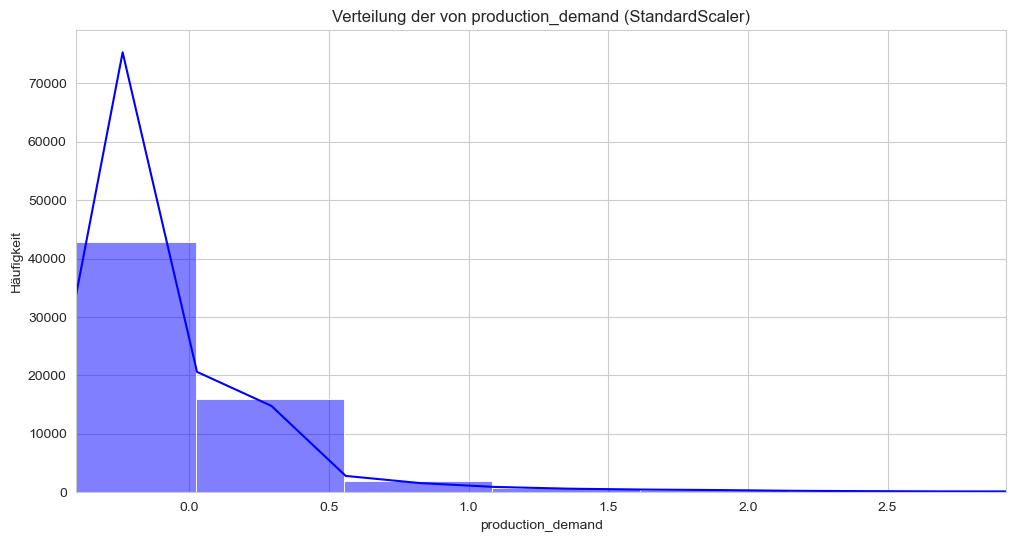

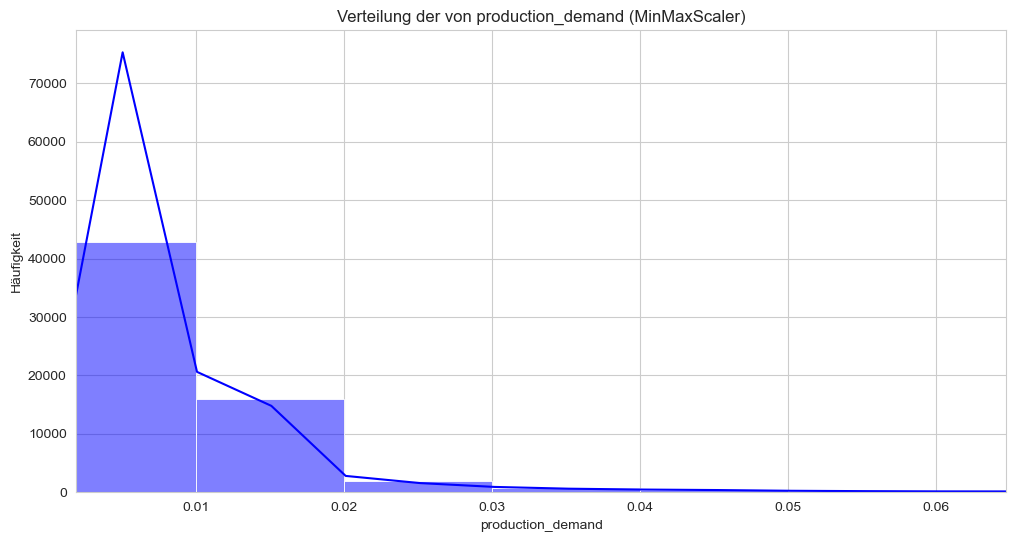

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler

features = ['production_demand', 'stock', 'net_raw_demand', 'preview_sum']
feature = 'production_demand'

data = pd.read_csv('data/processed_data.csv')
data = data[data[feature] > 0]
#data = data[(data[feature] >= 0) & (data[feature] <= 2000)]
#data = data[(data[feature] >= 20000)]

scalers = {
    'Original': None,
    'Log': lambda x: np.log1p(x),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
}

# Plots generieren
for name, scaler in scalers.items():
    transformed_data = data[[feature]].copy()

    if scaler is None:
        transformed_data[feature] = data[feature]
    elif callable(scaler):
        transformed_data[feature] = scaler(data[feature])
    else:
        transformed_data[feature] = scaler.fit_transform(data[[feature]])

    # Histogramm
    plt.figure(figsize=(12, 6))
    sns.histplot(transformed_data[feature], bins=100, kde=True, color='blue')
    plt.title(f'Verteilung der von {feature} ({name})')
    plt.xlabel(feature)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.xlim(transformed_data[feature].quantile(0.01), transformed_data[feature].quantile(0.99))
    plt.show()

    # Boxplot
    #plt.figure(figsize=(12, 6))
    #sns.boxplot(x=transformed_data[feature], color='orange')
    #plt.title(f'Boxplot der Produktionswerte ({name})')
    #plt.xlabel('Produktionswert')
    #plt.xlim(transformed_data[feature].quantile(0.01), transformed_data[feature].quantile(0.99))
    #plt.grid(True)
    #plt.show()


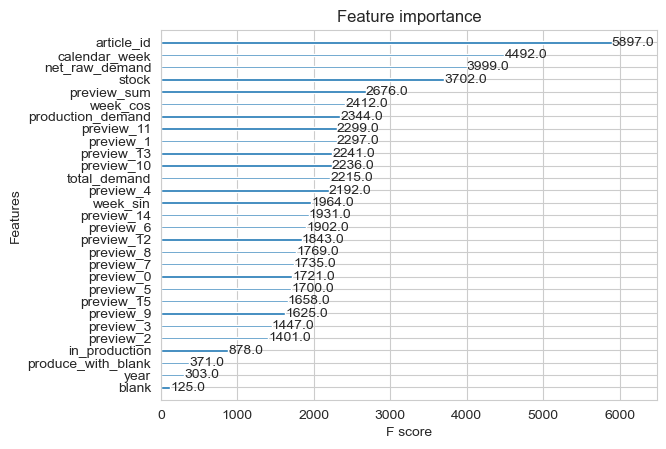

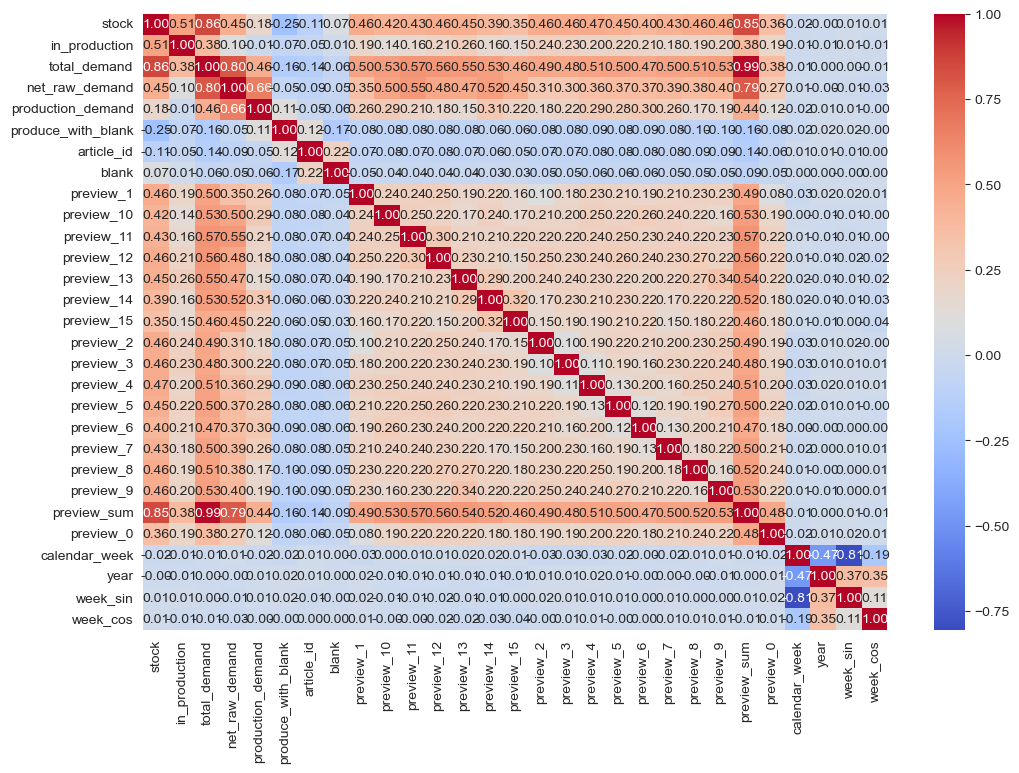

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/processed_data.csv')
df.drop('id', axis=1, inplace=True)

x = df.drop(columns=['production'])
y = df['production']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

def load_model():
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

def plot_feature_importance(model):
    xgb.plot_importance(model)
    plt.show()

def plot_correlation_matrix(x_train):
    plt.figure(figsize=(12, 8))
    correlation_matrix = x_train.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

plot_feature_importance(load_model())
plot_correlation_matrix(x_train)

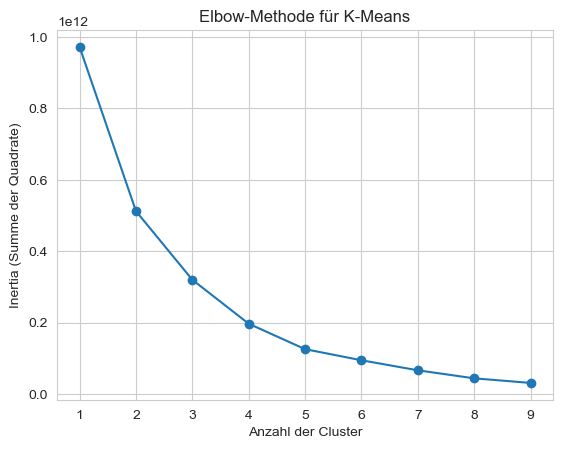

            count          mean           std  min  25%  50%      75%  \
cluster                                                                 
0        169157.0    474.154401    809.737629  0.0  0.0  0.0   1000.0   
1           250.0  21410.000000  38803.863976  0.0  0.0  0.0  36750.0   
2         14007.0   1430.436924   2962.029195  0.0  0.0  0.0   1000.0   
3          1493.0   6469.859344  11328.824055  0.0  0.0  0.0  13000.0   

              max  
cluster            
0          8000.0  
1        193000.0  
2         23000.0  
3         58500.0  


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv("data/processed_data.csv")

x = df[['production_demand']].values

inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Inertia (Summe der Quadrate)")
plt.title("Elbow-Methode für K-Means")
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(x)

print(df.groupby("cluster")["production_demand"].describe())
